In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import multiprocessing
import time as tm
from skimage import measure
from scipy.ndimage import rotate


params = dict()
params['pixel_ratio'] = 440
params['output_path'] = '/ExampleOutput/'

mins = 1. #3.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

simulation length: 1.0 mins = 60000 ms


In [2]:
prm = dict()
prm['pixel_ratio'] = 440
prm['output_path'] = 'ExampleOutput/'

In [5]:
# spatial_firing = pd.read_pickle('ExampleData/spatial_firing.pkl')
# print(spatial_firing.columns)
# position = pd.read_pickle('ExampleData/position.pkl')
# print(position.columns)

spike_data = pd.read_pickle('grid_cell_analysis-master/ExampleData/spike_data.pkl')

spike_data['position_x_pixels'] = spike_data['position_x'] / 100 * prm['pixel_ratio']
spike_data['position_y_pixels'] = spike_data['position_y'] / 100 * prm['pixel_ratio']

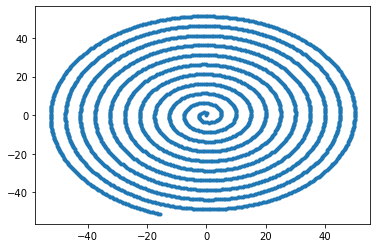

In [6]:
dt = 20
t = np.arange(0,sim_len,dt)*1.
time = [i * 1. for i in t if i < sim_len]
ts = np.arange(0,sim_len,dt)/1000.
V = 30
dr = 5
ph = np.sqrt(((V * (4*np.pi) * ts) / dr))
ra =  np.sqrt(((V * dr * ts) / np.pi))

pos_x = ra * np.cos(ph) 
pos_y = ra * np.sin(ph)
plt.plot(pos_x,pos_y,'.')

In [7]:
spatial_data = dict()
spatial_data['position_x'] = pos_x - min(pos_x)
spatial_data['position_y'] = pos_y - min(pos_y)

# pixels = cm / 100 * prm['pixel_ratio']
spatial_data['position_x_pixels'] = spatial_data['position_x'] / 100 * prm['pixel_ratio']
spatial_data['position_y_pixels'] = spatial_data['position_y'] / 100 * prm['pixel_ratio']

spatial_data = pd.DataFrame.from_dict(spatial_data)

I will plot a heat map of the position of the animal to show coverage.


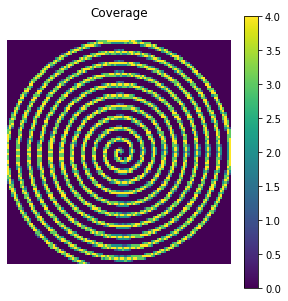

In [8]:
def get_dwell():
    min_dwell_distance_cm = 5  # from point to determine min dwell time

    dt_position_ms = 20  # average sampling interval in position data (ms)
    min_dwell_time_ms = 3 * dt_position_ms  # this is about 100 ms
    min_dwell = round(min_dwell_time_ms/dt_position_ms)
    return min_dwell, min_dwell_distance_cm

def get_bin_size(prm):
    bin_size_cm = 1
    bin_size_pixels = bin_size_cm / 100 * prm['pixel_ratio']
    return bin_size_pixels

def get_number_of_bins(spatial_data, prm):
    bin_size_pixels = get_bin_size(prm)
    length_of_arena_x = max(spatial_data.position_x) / 100 * prm['pixel_ratio']
    length_of_arena_y = max(spatial_data.position_y) / 100 * prm['pixel_ratio']
    number_of_bins_x = math.ceil(length_of_arena_x / bin_size_pixels)
    number_of_bins_y = math.ceil(length_of_arena_y / bin_size_pixels)
    return number_of_bins_x, number_of_bins_y

def style_open_field_plot(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tick_params(
        axis='both',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        right=False,
        left=False,
        labelleft=False,
        labelbottom=False)  # labels along the bottom edge are off

    ax.set_aspect('equal')
    return ax

def plot_coverage(position_heat_map, prm):
    print('I will plot a heat map of the position of the animal to show coverage.')
    save_path = prm['output_path'] + 'Figures/'
    if os.path.exists(save_path) is False:
        os.makedirs(save_path)
    coverage = plt.figure()
    coverage.set_size_inches(5, 5, forward=True)
    ax = coverage.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
    ax = style_open_field_plot(ax)
    position_heat_map = np.rot90(position_heat_map)
    coverage_fig = ax.imshow(position_heat_map, interpolation='nearest')
    coverage.colorbar(coverage_fig)
    plt.title('Coverage', y=1.08)
    plt.savefig(save_path + '/heatmap.png', dpi=300)
#     plt.savefig(save_path + '/heatmap.pdf')
#     plt.close()

def get_position_heatmap(spatial_data, prm):
    min_dwell,min_dwell_distance_cm = get_dwell()
    bin_size_cm = get_bin_size(prm)
    number_of_bins_x, number_of_bins_y = get_number_of_bins(spatial_data, prm)

    position_heat_map = np.zeros((number_of_bins_x, number_of_bins_y))

    # find value for each bin for heatmap
    for x in range(number_of_bins_x):
        for y in range(number_of_bins_y):
            px = x * bin_size_cm + (bin_size_cm / 2)
            py = y * bin_size_cm + (bin_size_cm / 2)

            occupancy_distances = np.sqrt(np.power((px - spatial_data.position_x_pixels), 2) + np.power((py - spatial_data.position_y_pixels), 2))
            bin_occupancy = len(np.where(occupancy_distances < min_dwell_distance_cm)[0])

#             if bin_occupancy >= min_dwell:
            position_heat_map[x, y] = bin_occupancy
#             else:
#                 position_heat_map[x, y] = None
    return position_heat_map

# plot how well the animal explored the arena
position_heat_map = get_position_heatmap(spatial_data, prm)
plot_coverage(position_heat_map, prm)

I will make scatter plots of spikes on the trajectory of the animal.


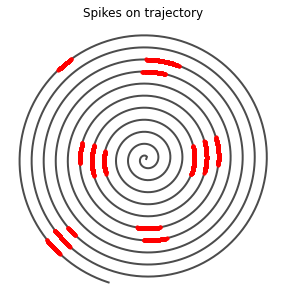

In [9]:
def plot_spikes_on_trajectory(spatial_data, spike_data, prm):
    print('I will make scatter plots of spikes on the trajectory of the animal.')
    save_path = prm['output_path'] + 'Figures/Spikes_on_Traj'
    if os.path.exists(save_path) is False:
        os.makedirs(save_path)

    for cluster_id in range(len(spike_data)):
        plt.close()
        spikes_on_track = plt.figure()
        spikes_on_track.set_size_inches(5, 5, forward=True)
        ax = spikes_on_track.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)

        ax.plot(spatial_data['position_x'], spatial_data['position_y'], color='black', linewidth=2, zorder=1, alpha=0.7)
        ax.scatter(spike_data.position_x[cluster_id], spike_data.position_y[cluster_id], color='red', marker='o', s=10, zorder=2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            right=False,
            left=False,
            labelleft=False,
            labelbottom=False)  # labels along the bottom edge are off
        ax.set_aspect('equal')
        plt.title('Spikes on trajectory')
        plt.savefig(save_path + '/cell_' + str(int(cluster_id)) + '_spikes_on_trajectory.png', dpi=300, bbox_inches='tight', pad_inches=0)
    #     plt.savefig(save_path + '/' + spike_data.session_id[cluster_id] + '_' + str(cluster_id + 1) + '_spikes_on_trajectory.pdf', bbox_inches='tight')
        
# plot spikes on the trajectory of the animal
plot_spikes_on_trajectory(spatial_data, spike_data, prm)

In [58]:
def gaussian_kernel(kernx):
    kerny = np.exp(np.power(kernx, 2)/2 * (-1))
    return kerny

def calculate_firing_rate_for_cluster_parallel(cluster, smooth, spike_data, positions_x, positions_y, number_of_bins_x, number_of_bins_y, bin_size_pixels, min_dwell, min_dwell_distance_pixels, dt_position_ms):
    print('Started another cluster')
    print(cluster)
    cluster_index = cluster
    cluster_firings = pd.DataFrame({'position_x': spike_data.position_x_pixels[cluster_index], 'position_y': spike_data.position_y_pixels[cluster_index]})
    spike_positions_x = cluster_firings.position_x.values
    spike_positions_y = cluster_firings.position_y.values
    firing_rate_map = np.zeros((number_of_bins_x, number_of_bins_y))
    for x in range(number_of_bins_x):
        for y in range(number_of_bins_y):
            px = x * bin_size_pixels + (bin_size_pixels / 2)
            py = y * bin_size_pixels + (bin_size_pixels / 2)
            spike_distances = np.sqrt(np.power(px - spike_positions_x, 2) + np.power(py - spike_positions_y, 2))
            spike_distances = spike_distances[~np.isnan(spike_distances)]
            occupancy_distances = np.sqrt(np.power((px - positions_x), 2) + np.power((py - positions_y), 2))
            occupancy_distances = occupancy_distances[~np.isnan(occupancy_distances)]
            bin_occupancy = len(np.where(occupancy_distances < min_dwell_distance_pixels)[0])

            if bin_occupancy >= min_dwell:
                firing_rate_map[x, y] = sum(gaussian_kernel(spike_distances/smooth)) / (sum(gaussian_kernel(occupancy_distances/smooth)) * (dt_position_ms/1000))

            else:
                firing_rate_map[x, y] = 0
    #firing_rate_map = np.rot90(firing_rate_map)
    return firing_rate_map

def get_spike_heatmap_parallel(spatial_data, spike_data, prm):
    print('I will calculate firing rate maps now.')
    dt_position_ms = 20 #ms
    min_dwell, min_dwell_distance_pixels = get_dwell()
    smooth = 5 / 100 * prm['pixel_ratio']
    bin_size_pixels = get_bin_size(prm)
    number_of_bins_x, number_of_bins_y = get_number_of_bins(spatial_data, prm)
    time_start = tm.time()
    firing_rate_maps = []
    for cluster in range(len(spike_data)):
        firing_rate_map = calculate_firing_rate_for_cluster_parallel(cluster, smooth, spike_data, spatial_data.position_x_pixels, spatial_data.position_y_pixels, number_of_bins_x, number_of_bins_y, bin_size_pixels, min_dwell, min_dwell_distance_pixels, dt_position_ms)
        firing_rate_maps.append(firing_rate_map)
    time_end = tm.time()
    print('Making the rate maps took:')
    time_diff = time_end - time_start
    print(time_diff)
    spike_data['firing_maps'] = firing_rate_maps

    return spike_data

def find_maximum_firing_rate(spike_data):
    max_firing_rates = []
    for cell in set(spike_data.cell_id):
        cluster = np.where(spike_data.cell_id == cell)[0]
        firing_rate_map = np.array(spike_data.firing_maps[cluster])
        max_firing_rate = np.max(firing_rate_map.flatten())
        max_firing_rates.append(max_firing_rate)
    spike_data['max_firing_rate'] = max_firing_rates
    return spike_data

def make_firing_field_maps(spatial_data, spike_data, prm):
    position_heat_map = get_position_heatmap(spatial_data, prm)
    spike_data = get_spike_heatmap_parallel(spatial_data, spike_data, prm)
    #position_heat_map = np.rot90(position_heat_map)  # to rotate map to be like matlab plots
    spike_data = find_maximum_firing_rate(spike_data)
    return position_heat_map, spike_data

if not 'firing_maps' in spike_data:
    position_heat_map, spike_data = make_firing_field_maps(spatial_data, spike_data, prm)
    
spike_data.to_pickle("ExampleData/spike_data_withfiringMaps.pkl")

I will make rate map plots.


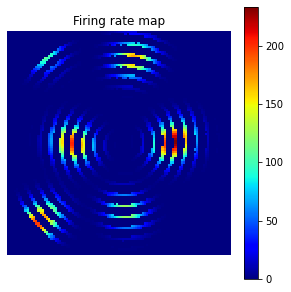

In [11]:
spike_data = pd.read_pickle('grid_cell_analysis-master/ExampleData/spike_data_withfiringMaps.pkl')

def style_open_field_plot(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tick_params(
        axis='both',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        right=False,
        left=False,
        labelleft=False,
        labelbottom=False)  # labels along the bottom edge are off

    ax.set_aspect('equal')
    return ax

def plot_firing_rate_maps(spike_data, prm):
    print('I will make rate map plots.')
    save_path = prm['output_path'] + '/Figures/rate_maps'
    if os.path.exists(save_path) is False:
        os.makedirs(save_path)
    for cluster in range(len(spike_data)):
        plt.close()
        firing_rate_map_original = spike_data.firing_maps[cluster]
        firing_rate_map = np.rot90(firing_rate_map_original)
        firing_rate_map_fig = plt.figure()
        firing_rate_map_fig.set_size_inches(5, 5, forward=True)
        ax = firing_rate_map_fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
        ax = style_open_field_plot(ax)
        rate_map_img = ax.imshow(firing_rate_map, cmap='jet', interpolation='nearest')
        firing_rate_map_fig.colorbar(rate_map_img)
        plt.title('Firing rate map')
        plt.savefig(save_path + '/cell_' + str(int(cluster)) + '_rate_map_.png', dpi=300)
        # plt.savefig(save_path + '/' + spike_data.session_id[cluster] + '_rate_map_' + str(cluster + 1) + '.pdf')
                
# plot firing rate maps
plot_firing_rate_maps(spike_data, prm)

In [23]:
def shift_2d(array_to_shift, n, axis):
    shifted_array = np.zeros_like(array_to_shift)
    if axis == 0:  # shift along x axis
        if n == 0:
            return array_to_shift
        if n > 0:
            shifted_array[:, :n] = 0
            shifted_array[:, n:] = array_to_shift[:, :-n]
        else:
            shifted_array[:, n:] = 0
            shifted_array[:, :n] = array_to_shift[:, -n:]

    if axis == 1:  # shift along y axis
        if n == 0:
            return array_to_shift
        elif n > 0:
            shifted_array[-n:, :] = 0
            shifted_array[:-n, :] = array_to_shift[n:, :]
        else:
            shifted_array[:-n, :] = 0
            shifted_array[-n:, :] = array_to_shift[:n, :]
    return shifted_array

def get_shifted_map(firing_rate_map, x, y):
    shifted_map = shift_2d(firing_rate_map, x, 0)
    shifted_map = shift_2d(shifted_map, y, 1)
    return shifted_map

def remove_nans(array1, array2):
    array2 = array2.flatten()
    array2[np.isnan(array2)] = 666
    array1 = array1.flatten()
    array1[np.isnan(array1)] = 666
    array2_tmp = np.take(array2, np.where(array1 != 666))
    array1_tmp = np.take(array1, np.where(array2 != 666))
    array2 = np.take(array2_tmp, np.where(array2_tmp[0] != 666))
    array1 = np.take(array1_tmp, np.where(array1_tmp[0] != 666))
    return array1.flatten(), array2.flatten()

def remove_zeros(array1, array2):
    array2 = np.nan_to_num(array2).flatten()
    array1 = np.nan_to_num(array1).flatten()
    array2_tmp = np.take(array2, np.where(array1 != 0))
    array1_tmp = np.take(array1, np.where(array2 != 0))
    array2 = np.take(array2_tmp, np.where(array2_tmp[0] != 0))
    array1 = np.take(array1_tmp, np.where(array1_tmp[0] != 0))
    return array1.flatten(), array2.flatten()

def get_rate_map_autocorrelogram(firing_rate_map):
    length_y = firing_rate_map.shape[0] - 1
    length_x = firing_rate_map.shape[1] - 1
    correlation_vector = np.empty((length_x * 2 + 1, length_y * 2 + 1)) * 0
    for shift_x in range(-length_x, length_x):
        for shift_y in range(-length_y, length_y):
            # shift map by x and y and remove extra bits
            shifted_map = get_shifted_map(firing_rate_map, shift_x, -shift_y)
            firing_rate_map_to_correlate, shifted_map = remove_zeros(firing_rate_map, shifted_map)

            correlation_y = shift_y + length_y
            correlation_x = shift_x + length_x

            if len(shifted_map) > 20:
                # np.corrcoef(x,y)[0][1] gives the same result for 1d vectors as matlab's corr(x,y) (Pearson)
                # https://stackoverflow.com/questions/16698811/what-is-the-difference-between-matlab-octave-corr-and-python-numpy-correlate
                correlation_vector[correlation_x, correlation_y] = np.corrcoef(firing_rate_map_to_correlate, shifted_map)[0][1]
            else:
                correlation_vector[correlation_x, correlation_y] = np.nan
    return correlation_vector

def threshold_autocorrelation_map(autocorrelation_map):
    autocorrelation_map[autocorrelation_map > 0.2] = 1
    autocorrelation_map[autocorrelation_map <= 0.2] = 0
    return autocorrelation_map

def find_autocorrelogram_peaks(autocorrelation_map):
    autocorrelation_map_thresholded = threshold_autocorrelation_map(autocorrelation_map)
    autocorr_map_labels = measure.label(autocorrelation_map_thresholded)  # each field is labelled with a single digit
    field_properties = measure.regionprops(autocorr_map_labels)
    return field_properties

def find_field_distances_from_mid_point(autocorr_map, field_properties):
    distances = []
    mid_point_coord_x = np.ceil(autocorr_map.shape[0] / 2)
    mid_point_coord_y = np.ceil(autocorr_map.shape[1] / 2)

    for field in range(len(field_properties)):
        field_central_x = field_properties[field].centroid[0]
        field_central_y = field_properties[field].centroid[1]
        distance = np.sqrt(np.square(field_central_x - mid_point_coord_x) + np.square(field_central_y - mid_point_coord_y))
        distances.append(distance)
    return distances


def get_ring_distances(field_distances_from_mid_point):
    field_distances_from_mid_point = np.array(field_distances_from_mid_point)[~np.isnan(field_distances_from_mid_point)]
    ring_distances = np.sort(field_distances_from_mid_point)[1:7]
    return ring_distances

def calculate_grid_spacing(field_distances, bin_size):
    grid_spacing = np.median(field_distances) * bin_size
    return grid_spacing

def calculate_field_size(field_properties, field_distances, bin_size):
    central_field_index = np.argmin(field_distances)
    field_size_pixels = field_properties[central_field_index].area  # number of pixels in central field
    field_size = np.sqrt(field_size_pixels * np.squeeze(bin_size)) / np.pi
    return field_size


def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= radius ** 2

#  replace values not in the grid ring with nan
def remove_inside_and_outside_of_grid_ring(autocorr_map, field_properties, field_distances):
    ring_distances = get_ring_distances(field_distances)
    inner_radius = (np.mean(ring_distances) * 0.5) / 2
    outer_radius = (np.mean(ring_distances) * 2.5) / 2
    center_x = field_properties[np.argmin(field_distances)].centroid[0]
    center_y = field_properties[np.argmin(field_distances)].centroid[1]
    for row in range(autocorr_map.shape[0]):
        for column in range(autocorr_map.shape[1]):
            in_ring = in_circle(center_x, center_y, outer_radius, row, column)
            in_middle = in_circle(center_x, center_y, inner_radius, row, column)
            if not in_ring or in_middle:
                autocorr_map[row, column] = np.nan
    return autocorr_map

def calculate_grid_score(autocorr_map, field_properties, field_distances):
    correlation_coefficients = []
    for angle in range(30, 180, 30):
        autocorr_map_to_rotate = np.nan_to_num(autocorr_map)
        rotated_map = rotate(autocorr_map_to_rotate, angle, reshape=False)  # todo fix this
        rotated_map_binary = np.round(rotated_map)
        autocorr_map_ring = remove_inside_and_outside_of_grid_ring(autocorr_map, field_properties, field_distances)
        rotated_map_ring = remove_inside_and_outside_of_grid_ring(rotated_map_binary, field_properties, field_distances)
        autocorr_map_ring_to_correlate, rotated_map_ring_to_correlate = remove_nans(autocorr_map_ring, rotated_map_ring)
        pearson_coeff = np.corrcoef(autocorr_map_ring_to_correlate, rotated_map_ring_to_correlate)[0][1]
        correlation_coefficients.append(pearson_coeff)
    grid_score = min(correlation_coefficients[i] for i in [1, 3]) - max(correlation_coefficients[i] for i in [0, 2, 4])
    return grid_score

def calculate_grid_metrics(autocorr_map, field_properties):
    bin_size = 2.5  # cm
    field_distances_from_mid_point = find_field_distances_from_mid_point(autocorr_map, field_properties)
    # the field with the shortest distance is the middle and the next 6 closest are the middle 6
    ring_distances = get_ring_distances(field_distances_from_mid_point)
    grid_spacing = calculate_grid_spacing(ring_distances, bin_size)
    field_size = calculate_field_size(field_properties, field_distances_from_mid_point, bin_size)
    grid_score = calculate_grid_score(autocorr_map, field_properties, field_distances_from_mid_point)
    return grid_spacing, field_size, grid_score

def process_grid_data(spike_data):
    rate_map_correlograms = []
    grid_spacings = []
    field_sizes = []
    grid_scores = []
    for index, cluster in spike_data.iterrows():
        firing_rate_map = cluster.firing_maps
        rate_map_correlogram = get_rate_map_autocorrelogram(firing_rate_map)
        rate_map_correlograms.append(np.copy(rate_map_correlogram))
        field_properties = find_autocorrelogram_peaks(rate_map_correlogram)
        if len(field_properties) > 7:
            grid_spacing, field_size, grid_score = calculate_grid_metrics(rate_map_correlogram, field_properties)
            grid_spacings.append(grid_spacing)
            field_sizes.append(field_size)
            grid_scores.append(grid_score)
        else:
            print('Not enough fields to calculate grid metrics.')
            grid_spacings.append(np.nan)
            field_sizes.append(np.nan)
            grid_scores.append(np.nan)
    spike_data['rate_map_autocorrelogram'] = rate_map_correlograms
    spike_data['grid_spacing'] = grid_spacings
    spike_data['field_size'] = field_sizes
    spike_data['grid_score'] = grid_scores
    return spike_data

spike_data = process_grid_data(spike_data)

spike_data.to_pickle("grid_cell_analysis-master/ExampleData/spike_data_withGridMetrics.pkl")

In [24]:
def plot_rate_map_autocorrelogram(spike_data, prm):
    print('I will make the rate map autocorrelogram grid plots now.')
    save_path = prm['output_path'] + '/Figures/rate_map_autocorrelogram'
    if os.path.exists(save_path) is False:
        os.makedirs(save_path)
    for cluster in range(len(spike_data)):
        rate_map_autocorr_fig = plt.figure()
        rate_map_autocorr_fig.set_size_inches(5, 5, forward=True)
        ax = rate_map_autocorr_fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
        rate_map_autocorr = spike_data.rate_map_autocorrelogram[cluster]
        if rate_map_autocorr.size:
            ax = plt.subplot(1, 1, 1)
            ax = style_open_field_plot(ax)
            autocorr_img = ax.imshow(rate_map_autocorr, cmap='jet', interpolation='nearest')
            rate_map_autocorr_fig.colorbar(autocorr_img)
            plt.tight_layout()
            plt.title('Autocorrelogram \n grid score: ' + str(round(spike_data.grid_score[cluster], 2)), fontsize=24)
            plt.savefig(save_path + '/cell_' + str(int(cluster)) + '_rate_map_autocorrelogram_.png', dpi=300, bbox_inches="tight")
            # plt.savefig(save_path + '/' + spike_data.session_id[cluster] + '_rate_map_autocorrelogram_' + str(cluster + 1) + '.pdf', bbox_inches="tight")
        plt.close()
        
plot_rate_map_autocorrelogram(spike_data, prm)

I will make the rate map autocorrelogram grid plots now.


<ipython-input-24-792e011fbd6f>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(1, 1, 1)


In [ ]:
# # also rerun the grid cell analysis
# spatial_firing = PostSorting.open_field_grid_cells.process_grid_data(spatial_firing)

# # plot the autocorrelograms of the firing rate maps
# PostSorting.open_field_make_plots.plot_rate_map_autocorrelogram(spatial_firing, prm)

# # get the head direction histogram from the trajectory and rerun hd analyses
# hd_histogram, spatial_firing = PostSorting.open_field_head_direction.process_hd_data(spatial_firing,
#                                                                                      position, prm)
# # plot traditional polar head direction plots
# PostSorting.open_field_make_plots.plot_polar_head_direction_histogram(hd_histogram, spatial_firing, prm)

# # plot head direction in individual firing fields
# PostSorting.open_field_make_plots.plot_hd_for_firing_fields(spatial_firing, position, prm)


In [25]:
# spike_data

,cell_id,mean_firing_rate,number_of_spikes,position_x,position_y,spike_times,position_x_pixels,position_y_pixels,firing_maps,max_firing_rate,rate_map_autocorrelogram,grid_spacing,field_size,grid_score
0,1.0,21.200000,1272.0,"[52.834110766329, 52.834110766329, 52.83411076...","[52.114728786216624, 52.114728786216624, 52.11...","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 40.0, 40....","[232.4700873718476, 232.4700873718476, 232.470...","[229.30480665935315, 229.30480665935315, 229.3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",106.670482,10.375633,0.444361
1,2.0,25.766667,1546.0,"[52.834110766329, 52.834110766329, 52.83411076...","[52.114728786216624, 52.114728786216624, 52.11...","[20.0, 20.0, 20.0, 20.0, 20.0, 40.0, 40.0, 40....","[232.4700873718476, 232.4700873718476, 232.470...","[229.30480665935315, 229.30480665935315, 229.3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",107.366663,10.593074,0.383880
2,3.0,29.283333,1757.0,"[52.834110766329, 52.834110766329, 52.27749630...","[52.114728786216624, 52.114728786216624, 52.55...","[20.0, 20.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40....","[232.4700873718476, 232.4700873718476, 230.020...","[229.30480665935315, 229.30480665935315, 231.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",97.404203,10.664569,0.350424
3,4.0,34.066667,2044.0,"[52.834110766329, 50.489411461840355, 50.48941...","[52.114728786216624, 52.03667464772444, 52.036...","[20.0, 100.0, 100.0, 100.0, 100.0, 120.0, 120....","[232.4700873718476, 222.15341043209753, 222.15...","[229.30480665935315, 228.9613684499875, 228.96...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",96.767956,10.688294,0.504333
4,5.0,34.866667,2092.0,"[52.834110766329, 46.211462910016216, 46.21146...","[52.114728786216624, 54.510187020010285, 54.51...","[20.0, 1060.0, 1060.0, 1060.0, 1080.0, 1080.0,...","[232.4700873718476, 203.33043680407135, 203.33...","[229.30480665935315, 239.84482288804523, 239.8...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",106.345062,10.545141,0.760347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356.0,36.016667,2161.0,"[46.211462910016216, 46.211462910016216, 46.21...","[54.510187020010285, 54.510187020010285, 54.51...","[1060.0, 1060.0, 1060.0, 1060.0, 1060.0, 1080....","[203.33043680407135, 203.33043680407135, 203.3...","[239.84482288804523, 239.84482288804523, 239.8...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",62.557342,10.351191,-0.047153
356,357.0,36.450000,2187.0,"[45.39446281762136, 41.127854984726405, 40.887...","[52.89942506044183, 55.61195563499732, 55.0607...","[1120.0, 3120.0, 3140.0, 3140.0, 3140.0, 3140....","[199.735636397534, 180.96256193279618, 179.906...","[232.75747026594405, 244.6926047939882, 242.26...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",71.322770,10.277516,-0.039713
357,358.0,33.133333,1988.0,"[40.675086195764294, 40.675086195764294, 40.67...","[54.4984404715451, 54.4984404715451, 54.498440...","[3160.0, 3160.0, 3160.0, 3180.0, 3180.0, 3180....","[178.9703792613629, 178.9703792613629, 178.970...","[239.79313807479846, 239.79313807479846, 239.7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",105.748